
![<Caribbeans for Climate>](../CFC_logo.PNG "black background with Caribbeans for Climate in green writing")
![<CMIP6>](./images/logos/cmip_logo.jpeg "image alt text")


## Caribbean precipitation extremes using HighResMIP

---

## Overview

In this notebook, we'll do the following:
- Learn how to make subregional-scale plots with the CMIP6 model output
- Plot spatial trends in summertime environmental variables
- Calculate the genesis potential index (GPI), an indicator of environmental favorability for tropical cyclogenesis


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Load CMIP6 data with Intake-ESM](https://projectpythia.org/cmip6-cookbook/notebooks/foundations/intake-esm.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 30 minutes.


---

## Installs

Before you start, install the [xMIP](https://github.com/jbusecke/xMIP), [regionmask](https://regionmask.readthedocs.io/en/stable/index.html), and [tcpyPI](https://github.com/dgilford/tcpyPI/tree/master) packages. These packages allow us to mask and handle the bulky CMIP6 model output with ease. ```tcpyPI``` helps us calculate the potential intensity of storms given certain environmental conditions. Remove ```-q``` below for ```pip install``` output.


In [5]:
# !pip install -q git+https://github.com/jbusecke/xmip.git

In [6]:
# !pip install -q regionmask==0.12.1

In [4]:
# !pip install -q tcpypi

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import intake
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds

from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker

plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['figure.titlesize'] = 15
plt.rcParams["axes.titlesize"] = 15

## Initiate compute cluster


In [2]:
import os
import sys
from dask_gateway import Gateway
from dask.distributed import Client


platform = sys.platform

if (platform == 'win32'):
    import multiprocessing.popen_spawn_win32
else:
    import multiprocessing.popen_spawn_posix

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36509,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:44589,Total threads: 1
Dashboard: http://127.0.0.1:44981/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:38807,


Once you initiate your ```Client```, navigate to the ```Dask```![<Dask>](dask_icon_v2.ico "Dask logo") tab in the far-left sidebar or click the ```Launch dashboard in JupyterLab``` button above. In the search bar at the top, input your cluster's url. Then, replace ```https://127.0.0.1:``` with ```/proxy/```.

## Load the CMIP6 HighResMIP data

Since we're <ins>examining precipitation extremes at regional scales</ins>, it's good to use the highest resolution data available. In this notebook, we'll use the **HighResMIP experiments**, that provide a relatively higher resolution than the CMIP6 data. In this section, we'll choose one global climate model (as an example, NOAA GFDL's GFDL-CM4C192 model) for our analyses. We'll grab the following environmental variables:
- Omega (wap)
- Convective precipitation (prc)
- Mean sea-level pressure (psl)
- Eastward, Meridional (horizontal) winds (ua, va)
- Relative humidity (hur)
- Specific humidity (hus)

Below, we're using ```Intake-ESM``` to grab the model, experiments, and variables we want. ```Intake-ESM``` packages all of our data into two datasets (by experiment).

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


Use the column headers above to refine your catalog search. Here's a handy [list of CMIP6 experiments and variables](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit?usp=sharing) to help your search.

In [5]:
cat = col.search(activity_id='HighResMIP', 
                 institution_id='NOAA-GFDL', 
                 experiment_id=['highresSST-present', 'highresSST-future'],
                 table_id='Amon',
                 variable_id=['psl', 'tas', 'wap', 'prc', 'hur', 'ua', 'va', 'hus'])

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,wap,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
1,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,ua,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
2,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,psl,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
3,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,prc,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
4,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,hus,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
5,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,hur,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
6,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,va,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
7,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-present,r1i1p1f1,Amon,prc,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
8,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-present,r1i1p1f1,Amon,hus,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
9,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-present,r1i1p1f1,Amon,hur,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701


In [6]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-future.Amon.gr3',
 'HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-present.Amon.gr3']

We'll consolidate our catalog into two datasets, then merge with ```xarray.concat``` to create a larger dataset.

In [7]:
dsPRES = dset_dict['HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-present.Amon.gr3'].squeeze()
dsFUT = dset_dict['HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-future.Amon.gr3'].squeeze()
dsFULL = xr.concat([dsPRES, dsFUT], dim="time")
dsFULL

<xarray.Dataset> Size: 99GB
Dimensions:         (time: 1212, plev: 19, lat: 360, lon: 576, bnds: 2)
Coordinates:
  * bnds            (bnds) float64 16B 1.0 2.0
  * lat             (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    lat_bnds        (lat, bnds) float64 6kB -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
  * lon             (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
    lon_bnds        (lon, bnds) float64 9kB 0.0 0.625 0.625 ... 359.4 360.0
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
  * time            (time) object 10kB 1950-01-16 12:00:00 ... 2050-12-16 12:...
    time_bnds       (time, bnds) object 19kB dask.array<chunksize=(780, 2), meta=np.ndarray>
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
    height          float64 8B 2.0
Data variables:
    hur             (time, plev, lat, lon) float32 19GB dask.array<chunksize=(5, 19, 360, 576), meta=np.ndarray>
    hus             (time, plev, lat, lon) float32 19GB dask.array<chunksize=(5, 19, 360, 576), meta=np.ndarray>
    prc             (time, lat, lon) float32 1GB dask.array<chunksize=(85, 360, 576), meta=np.ndarray>
    psl             (time, lat, lon) float32 1GB dask.array<chunksize=(131, 360, 576), meta=np.ndarray>
    tas             (time, lat, lon) float32 1GB dask.array<chunksize=(112, 360, 576), meta=np.ndarray>
    ua              (time, plev, lat, lon) float32 19GB dask.array<chunksize=(4, 19, 360, 576), meta=np.ndarray>
    va              (time, plev, lat, lon) float32 19GB dask.array<chunksize=(4, 19, 360, 576), meta=np.ndarray>
    wap             (time, plev, lat, lon) float32 19GB dask.array<chunksize=(4, 19, 360, 576), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      HighResMIP
    branch_method:                    none provided
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr3
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           HighResMIP.NOAA-GFDL.GFDL-CM4C192.highr...

## The global warming trend: Creating spatial trend maps

We understand that the Earth is warming from increasing linear trends in global mean surface temperatures. But, not everywhere warms at the same rate. This is known as the pattern effect, and it results in more complex global and regional climate change impacts. Using ```xarray```, we can find the linear trend at each gridpoint in our data.

Let's calculate the trend in precipitation across the Caribbean for our GCM.

In [8]:
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# Calculate the global mean time series and linear trend from surface air temperatures
regional_mean = dsFULL.prc.sel(time=dsFULL.time.dt.month.isin([8,9,10]), lat=slice(10, 30), lon=slice(260, 310)).mean(['lat', 'lon'])
regional_anom = regional_mean.groupby('time.month') - regional_mean.groupby('time.month').mean('time')
regional_anom = regional_anom*1e4

# Use numpy lstsq to find linear trend
x = np.arange(0, regional_anom.time.shape[0])
A = np.vstack([x, np.ones(len(x))]).T

# Calculate the least squares fit
m, c = np.linalg.lstsq(A, regional_anom.values, rcond=None)[0]
prc_linear = m*x + c

# Calculate the linear trend at each grid point
da = dsFULL.prc.sel(time=dsFULL.time.dt.month.isin([8,9,10]), lat=slice(10, 30), lon=slice(260, 310)).groupby('time.year').mean('time')*1e4
res = da.polyfit(dim="year", deg=1)

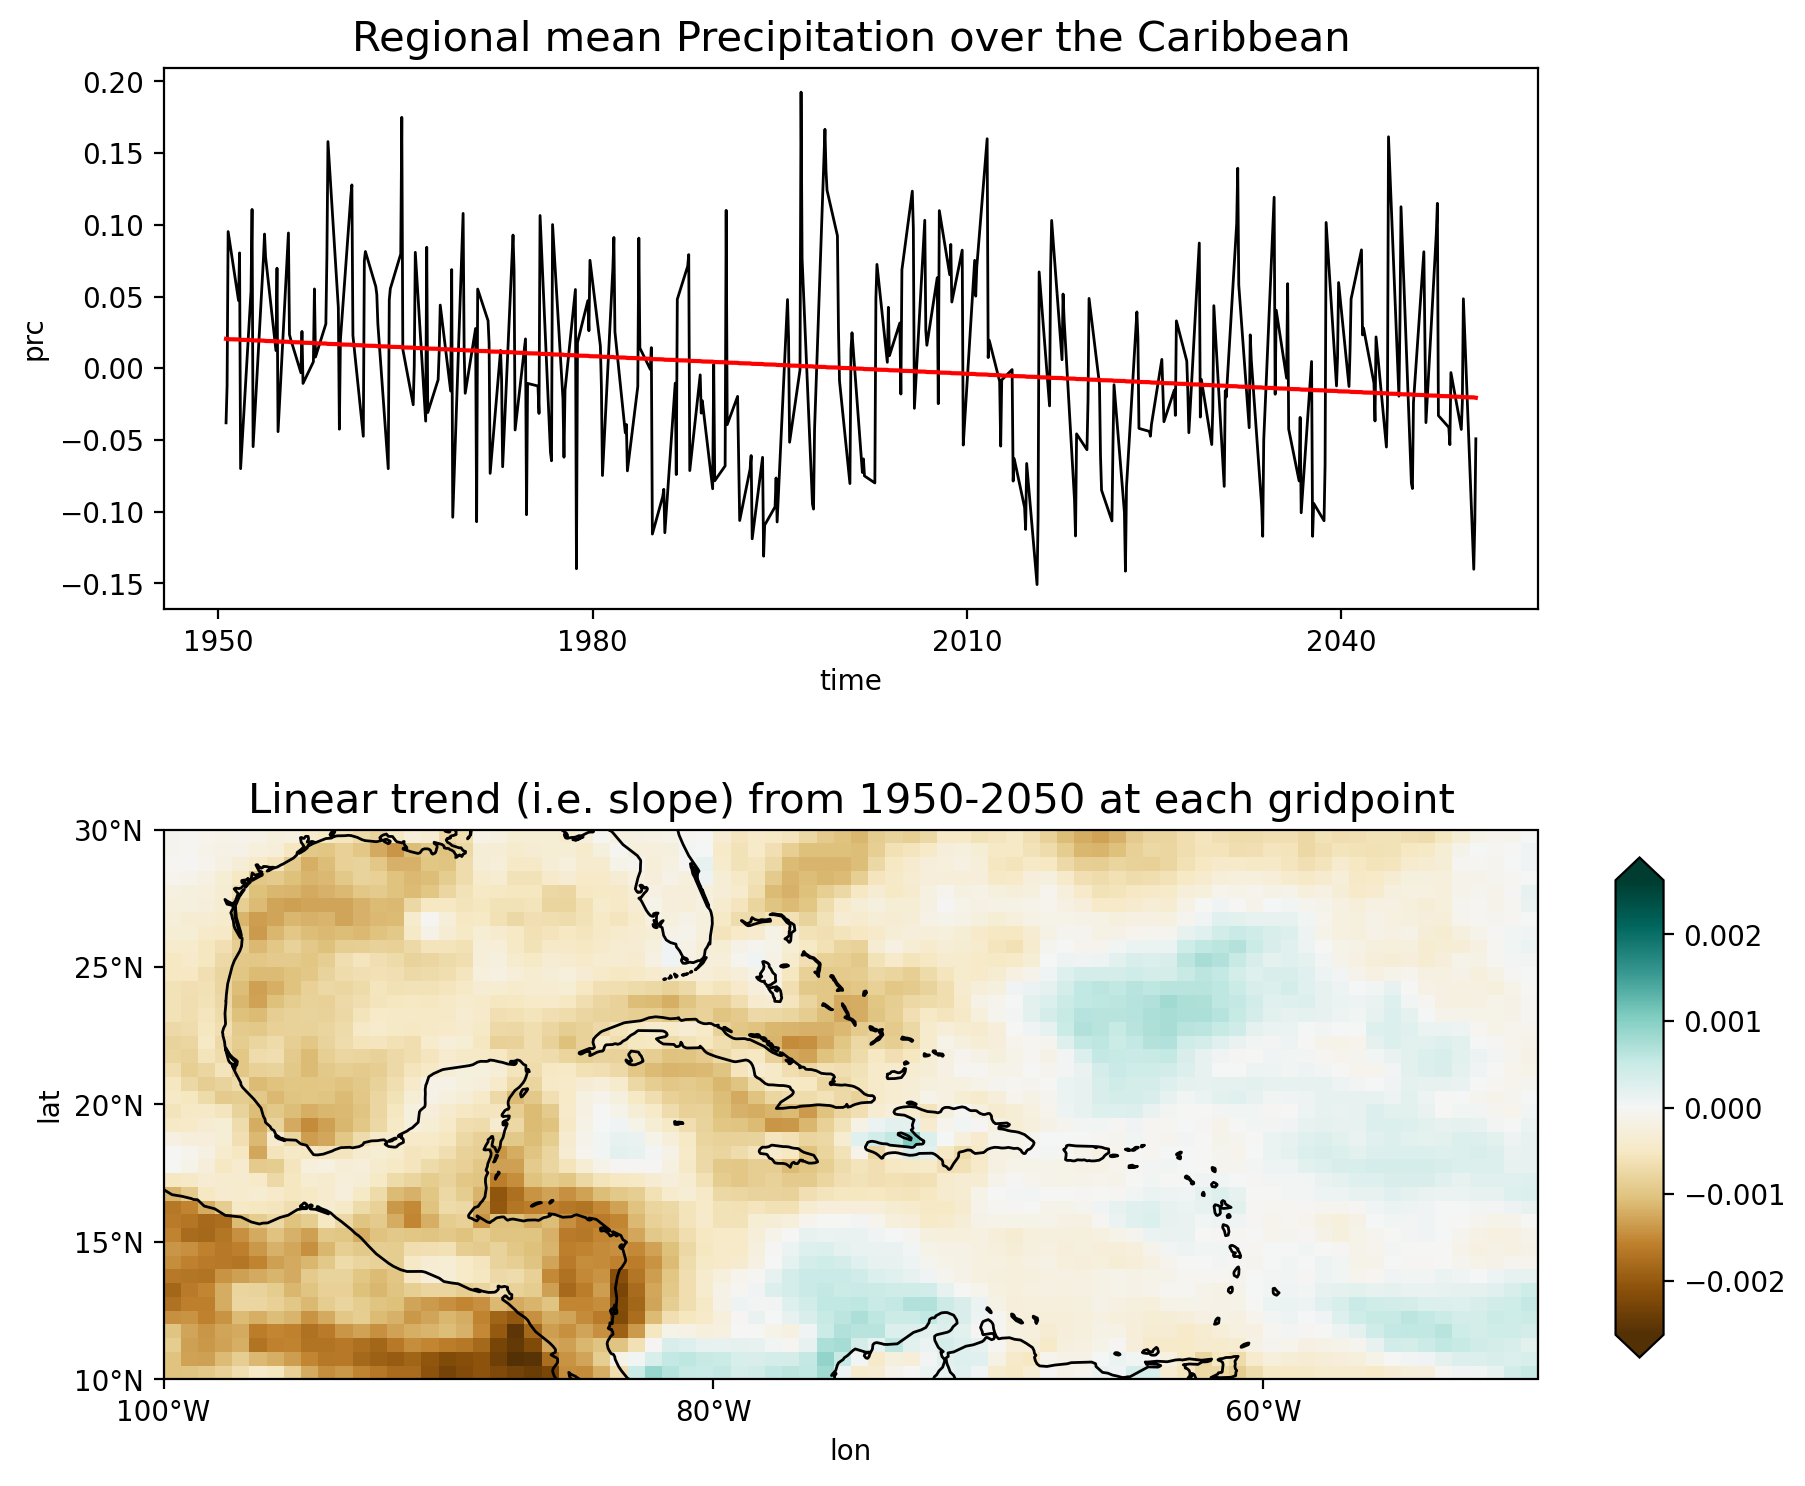

In [9]:
# Plot results
fig = plt.figure(figsize=(12,10), dpi=200)

gs = gridspec.GridSpec(2, 4, height_ratios=[0.35, 0.65], hspace=-0.01) 

ax1= fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[1:2, 0:3], projection=ccrs.PlateCarree())

# First subplot
regional_anom.plot(ax=ax1, linewidth=1, color='black')
ax1.plot(regional_anom.time, prc_linear, color='red')
ax1.set_title('Regional mean Precipitation over the Caribbean')

# Second subplot
ax2.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

ax2.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(10, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)

fc = res.polyfit_coefficients.sel(degree=1).plot(ax=ax2, cmap=plt.cm.BrBG, extend='both', add_colorbar=False)
ax2.set_title('Linear trend (i.e. slope) from 1950-2050 at each gridpoint')

cax1 = fig.add_axes([0.73, 0.235, 0.02, 0.25])
cbar = fig.colorbar(fc, cax=cax1, extend='both')


In our model, the Gulf of Mexico and western Caribbean regions experiences more drying relative to the eastern Caribbean. Another useful field to examine is the 500-hPa omega ($\omega500$ field, that tells us where deep convection occurs. Let's rerun the cells above to examine $\omega500$ trends. Note that, in contrast to precipitation, $\omega500$ is negative for upward motion (convective activity) and positive to downward motion (no convective activity).

In [10]:
# Calculate the global mean time series and linear trend from surface air temperatures
regional_mean = dsFULL.wap.sel(time=dsFULL.time.dt.month.isin([8,9,10]), lat=slice(10, 30), lon=slice(260, 310), plev=500*100).mean(['lat', 'lon'])
regional_anom = regional_mean.groupby('time.month') - regional_mean.groupby('time.month').mean('time')
regional_anom = regional_anom*1e2

# Use numpy lstsq to find linear trend
x = np.arange(0, regional_anom.time.shape[0])
A = np.vstack([x, np.ones(len(x))]).T

# Calculate the least squares fit
m, c = np.linalg.lstsq(A, regional_anom.values, rcond=None)[0]
prc_linear = m*x + c

# Calculate the linear trend at each grid point
da = dsFULL.wap.sel(time=dsFULL.time.dt.month.isin([8,9,10]), lat=slice(10, 30), lon=slice(260, 310), plev=500*100).groupby('time.year').mean('time')*1e2
res = da.polyfit(dim="year", deg=1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 101 times more chunks
  return self.array[key]


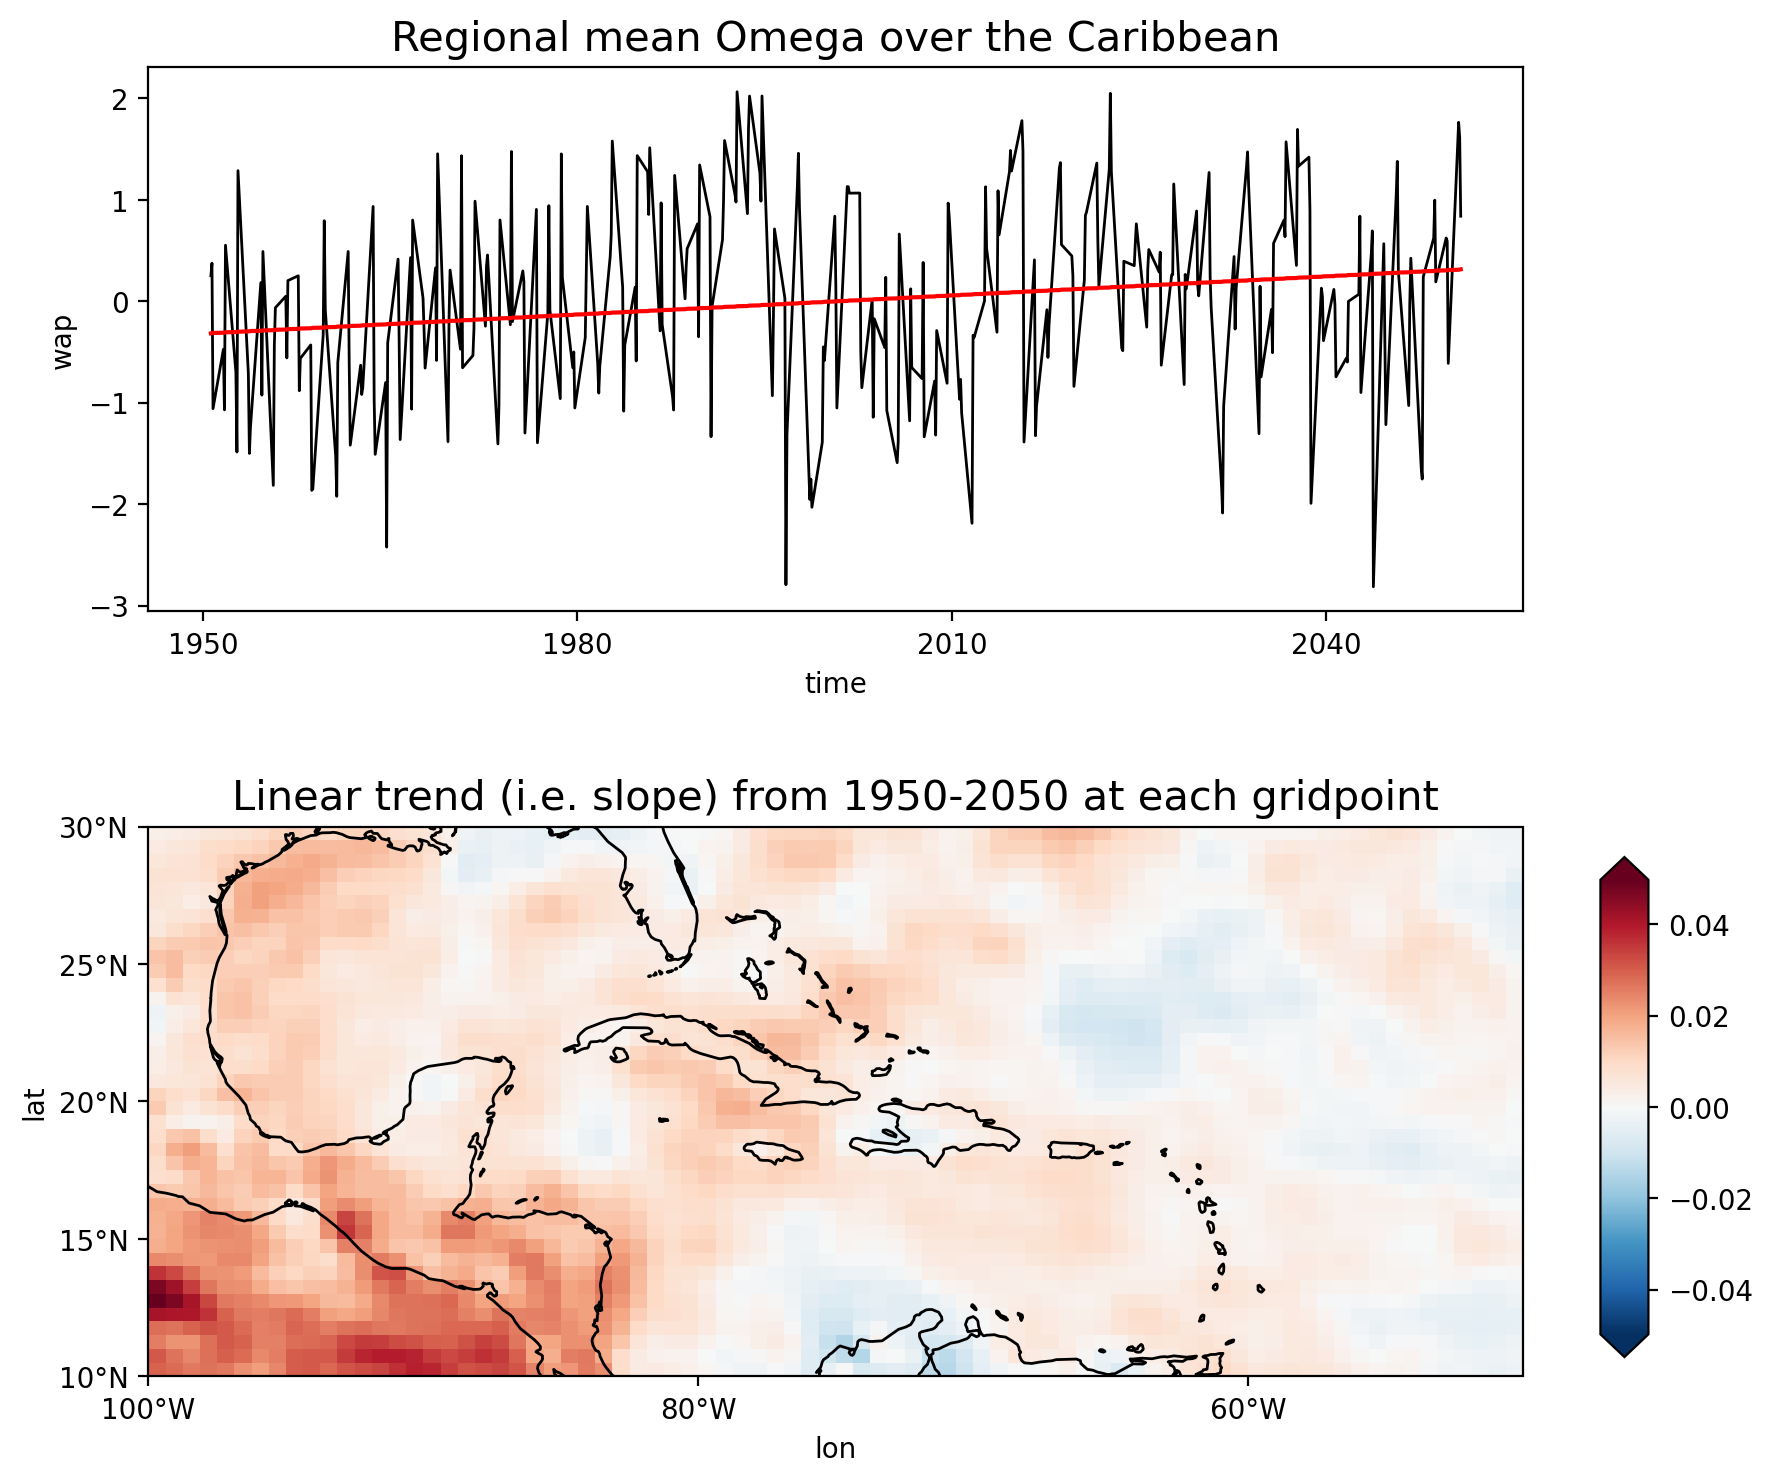

In [11]:
# Plot results
fig = plt.figure(figsize=(12,10), dpi=200)

gs = gridspec.GridSpec(2, 4, height_ratios=[0.35, 0.65], hspace=-0.02) 

ax1= fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[1:2, 0:3], projection=ccrs.PlateCarree())

# First subplot
regional_anom.plot(ax=ax1, linewidth=1, color='black')
ax1.plot(regional_anom.time, prc_linear, color='red')
ax1.set_title('Regional mean Omega over the Caribbean')

# Second subplot
ax2.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

ax2.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(10, 35, 5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)

fc = res.polyfit_coefficients.sel(degree=1).plot(ax=ax2, cmap=plt.cm.RdBu_r, extend='both', add_colorbar=False)
ax2.set_title('Linear trend (i.e. slope) from 1950-2050 at each gridpoint')

cax1 = fig.add_axes([0.73, 0.235, 0.02, 0.25])
cbar = fig.colorbar(fc, cax=cax1, extend='both')


## Examining environmental changes by experiment

Here, we look at the simulated 500-hPa omega ($\omega500$) fields for the _highresSST-Present_ and _highresSST-Future_. The $\omega500$ variable is a useful indicator for examining where extreme convection tends to occur.

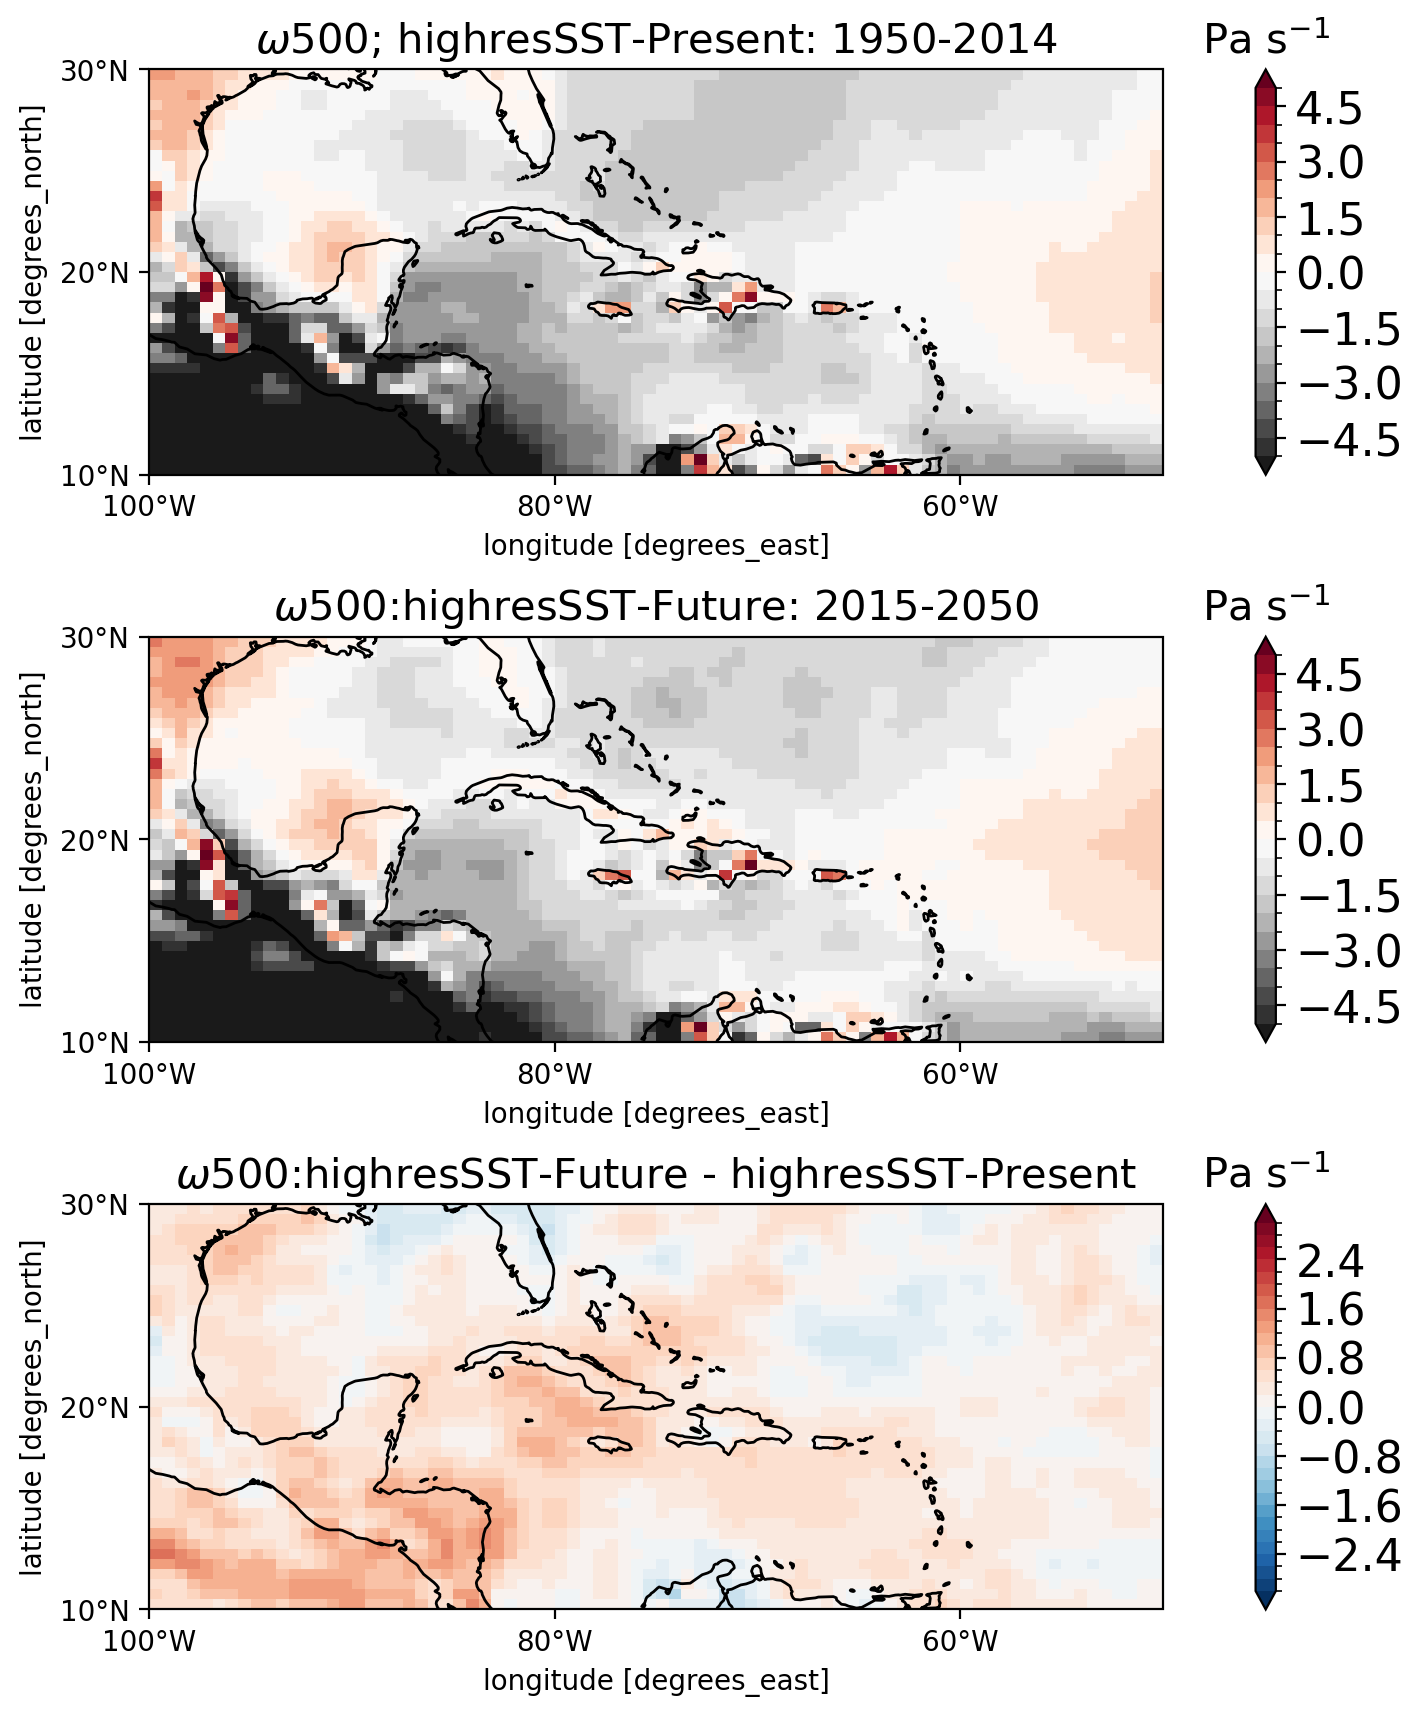

In [16]:
# Subset our data to only look at months August-October
da1_env = dsPRES.wap.sel(time=dsPRES.time.dt.month.isin([8,9,10]), plev=500*100).mean('time')*1e2
da2_env = dsFUT.wap.sel(time=dsFUT.time.dt.month.isin([8,9,10]), plev=500*100).mean('time')*1e2

difference = da2_env - da1_env

fig = plt.figure(figsize=(12,10), dpi=200)

ax = fig.add_subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

ax.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 40, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fc = da1_env.plot(levels=np.arange(-5, 5.5, 0.5), cmap=plt.cm.RdGy_r, extend='both', add_colorbar=False, ax=ax)
ax.set_title(r"$\omega500$; highresSST-Present: 1950-2014")

cbar = plt.colorbar(fc, orientation='vertical', ax=ax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title(r'Pa s$^{-1}$')

ax = fig.add_subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

ax.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 40, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fc = da2_env.plot(levels=np.arange(-5, 5.5, 0.5), cmap=plt.cm.RdGy_r, extend='both', add_colorbar=False, ax=ax)
ax.set_title(r"$\omega500$:highresSST-Future: 2015-2050")

cbar = plt.colorbar(fc, orientation='vertical', ax=ax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title(r'Pa s$^{-1}$')
        
ax = fig.add_subplot(3, 1, 3, projection=ccrs.PlateCarree())
ax.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

ax.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 40, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fc = difference.plot(levels=np.arange(-3, 3.2, 0.2), cmap=plt.cm.RdBu_r, extend='both', add_colorbar=False, ax=ax)
ax.set_title(r"$\omega500$:highresSST-Future - highresSST-Present")

cbar = plt.colorbar(fc, orientation='vertical', ax=ax)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title(r'Pa s$^{-1}$')

plt.subplots_adjust(hspace=0.4)

## Calculating potential intensity with TCPyPI

Here, we'll do something a little different. We'll retrieve some more data above to calculate what is known as genesis potential for the Caribbean region. Genesis potential is an indicator of how favorable 

In [4]:
client.close()

---

## Summary
In the above workflow, we examine environmental changes in the CMIP6 HighResMIP simulations and calculate changes in GPI, an indicator of tropical cyclone activity for the Caribbean region.

### What's next?
In the next book, we examine how El Niño Southern Oscillation (ENSO) variability is a key factor in this regional-scale variability and trends. 

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!